In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 1040)
(1078212, 3)
validation
(151755, 1040)
(151755, 3)
test
(135990, 1040)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:57 - loss: 1.1585 - STD: 0.0977 - MAE: 0.4458

  3/108 [..............................] - ETA: 2s - loss: 1.1377 - STD: 0.0932 - MAE: 0.4440  

  5/108 [>.............................] - ETA: 2s - loss: 1.1183 - STD: 0.0694 - MAE: 0.4427

  7/108 [>.............................] - ETA: 2s - loss: 1.1088 - STD: 0.0672 - MAE: 0.4410

  9/108 [=>............................] - ETA: 2s - loss: 1.0949 - STD: 0.0643 - MAE: 0.4383

 11/108 [==>...........................] - ETA: 2s - loss: 1.0757 - STD: 0.0625 - MAE: 0.4344

 13/108 [==>...........................] - ETA: 2s - loss: 1.0512 - STD: 0.0672 - MAE: 0.4286

 15/108 [===>..........................] - ETA: 2s - loss: 1.0198 - STD: 0.0776 - MAE: 0.4196

 17/108 [===>..........................] - ETA: 2s - loss: 0.9874 - STD: 0.0926 - MAE: 0.4088

 19/108 [====>.........................] - ETA: 2s - loss: 0.9561 - STD: 0.1095 - MAE: 0.3972

 21/108 [====>.........................] - ETA: 2s - loss: 0.9281 - STD: 0.1247 - MAE: 0.3865

 23/108 [=====>........................] - ETA: 2s - loss: 0.9033 - STD: 0.1386 - MAE: 0.3767

 25/108 [=====>........................] - ETA: 2s - loss: 0.8832 - STD: 0.1512 - MAE: 0.3681

 27/108 [======>.......................] - ETA: 2s - loss: 0.8647 - STD: 0.1622 - MAE: 0.3602

 29/108 [=======>......................] - ETA: 2s - loss: 0.8478 - STD: 0.1723 - MAE: 0.3529

 31/108 [=======>......................] - ETA: 2s - loss: 0.8321 - STD: 0.1808 - MAE: 0.3465

 33/108 [========>.....................] - ETA: 1s - loss: 0.8169 - STD: 0.1881 - MAE: 0.3407

 35/108 [========>.....................] - ETA: 1s - loss: 0.8036 - STD: 0.1940 - MAE: 0.3358

 37/108 [=========>....................] - ETA: 1s - loss: 0.7906 - STD: 0.1998 - MAE: 0.3309

 39/108 [=========>....................] - ETA: 1s - loss: 0.7787 - STD: 0.2053 - MAE: 0.3262

 41/108 [==========>...................] - ETA: 1s - loss: 0.7669 - STD: 0.2104 - MAE: 0.3217

 43/108 [==========>...................] - ETA: 1s - loss: 0.7552 - STD: 0.2154 - MAE: 0.3171

 45/108 [===========>..................] - ETA: 1s - loss: 0.7446 - STD: 0.2205 - MAE: 0.3125

 47/108 [============>.................] - ETA: 1s - loss: 0.7339 - STD: 0.2256 - MAE: 0.3079

 49/108 [============>.................] - ETA: 1s - loss: 0.7231 - STD: 0.2303 - MAE: 0.3033

 51/108 [=============>................] - ETA: 1s - loss: 0.7132 - STD: 0.2349 - MAE: 0.2990

 53/108 [=============>................] - ETA: 1s - loss: 0.7029 - STD: 0.2393 - MAE: 0.2946

 55/108 [==============>...............] - ETA: 1s - loss: 0.6928 - STD: 0.2434 - MAE: 0.2903

 57/108 [==============>...............] - ETA: 1s - loss: 0.6827 - STD: 0.2476 - MAE: 0.2860

 59/108 [===============>..............] - ETA: 1s - loss: 0.6731 - STD: 0.2516 - MAE: 0.2818

 61/108 [===============>..............] - ETA: 1s - loss: 0.6637 - STD: 0.2555 - MAE: 0.2777

 63/108 [================>.............] - ETA: 1s - loss: 0.6545 - STD: 0.2594 - MAE: 0.2735

 65/108 [=================>............] - ETA: 1s - loss: 0.6454 - STD: 0.2632 - MAE: 0.2694

 67/108 [=================>............] - ETA: 1s - loss: 0.6365 - STD: 0.2670 - MAE: 0.2653

 69/108 [==================>...........] - ETA: 1s - loss: 0.6282 - STD: 0.2706 - MAE: 0.2614

 71/108 [==================>...........] - ETA: 0s - loss: 0.6195 - STD: 0.2742 - MAE: 0.2575

 73/108 [===================>..........] - ETA: 0s - loss: 0.6112 - STD: 0.2776 - MAE: 0.2537

 75/108 [===================>..........] - ETA: 0s - loss: 0.6031 - STD: 0.2809 - MAE: 0.2500

 77/108 [====================>.........] - ETA: 0s - loss: 0.5951 - STD: 0.2840 - MAE: 0.2464

 79/108 [====================>.........] - ETA: 0s - loss: 0.5873 - STD: 0.2870 - MAE: 0.2430

 81/108 [=====================>........] - ETA: 0s - loss: 0.5795 - STD: 0.2900 - MAE: 0.2396

 83/108 [======================>.......] - ETA: 0s - loss: 0.5721 - STD: 0.2928 - MAE: 0.2364

 85/108 [======================>.......] - ETA: 0s - loss: 0.5650 - STD: 0.2955 - MAE: 0.2333

 87/108 [=======================>......] - ETA: 0s - loss: 0.5582 - STD: 0.2982 - MAE: 0.2302

 89/108 [=======================>......] - ETA: 0s - loss: 0.5515 - STD: 0.3008 - MAE: 0.2273

 91/108 [========================>.....] - ETA: 0s - loss: 0.5450 - STD: 0.3033 - MAE: 0.2244

 92/108 [========================>.....] - ETA: 0s - loss: 0.5423 - STD: 0.3045 - MAE: 0.2230

 94/108 [=========================>....] - ETA: 0s - loss: 0.5362 - STD: 0.3069 - MAE: 0.2203

 96/108 [=========================>....] - ETA: 0s - loss: 0.5303 - STD: 0.3092 - MAE: 0.2176

 98/108 [==========================>...] - ETA: 0s - loss: 0.5246 - STD: 0.3114 - MAE: 0.2151

100/108 [==========================>...] - ETA: 0s - loss: 0.5191 - STD: 0.3136 - MAE: 0.2127

102/108 [===========================>..] - ETA: 0s - loss: 0.5136 - STD: 0.3156 - MAE: 0.2103

104/108 [===========================>..] - ETA: 0s - loss: 0.5082 - STD: 0.3177 - MAE: 0.2079

106/108 [============================>.] - ETA: 0s - loss: 0.5030 - STD: 0.3196 - MAE: 0.2056

108/108 [==============================] - ETA: 0s - loss: 0.4979 - STD: 0.3215 - MAE: 0.2034

108/108 [==============================] - 6s 44ms/step - loss: 0.4979 - STD: 0.3215 - MAE: 0.2034 - val_loss: 0.2555 - val_STD: 0.4194 - val_MAE: 0.0947


Epoch 2/10000


  1/108 [..............................] - ETA: 6s - loss: 0.2348 - STD: 0.4230 - MAE: 0.0864

  3/108 [..............................] - ETA: 2s - loss: 0.2338 - STD: 0.4220 - MAE: 0.0869

  5/108 [>.............................] - ETA: 2s - loss: 0.2326 - STD: 0.4222 - MAE: 0.0865

  7/108 [>.............................] - ETA: 2s - loss: 0.2315 - STD: 0.4225 - MAE: 0.0862

  9/108 [=>............................] - ETA: 2s - loss: 0.2305 - STD: 0.4227 - MAE: 0.0857

 11/108 [==>...........................] - ETA: 2s - loss: 0.2290 - STD: 0.4227 - MAE: 0.0855

 13/108 [==>...........................] - ETA: 2s - loss: 0.2275 - STD: 0.4231 - MAE: 0.0849

 15/108 [===>..........................] - ETA: 2s - loss: 0.2260 - STD: 0.4232 - MAE: 0.0845

 17/108 [===>..........................] - ETA: 2s - loss: 0.2248 - STD: 0.4234 - MAE: 0.0841

 19/108 [====>.........................] - ETA: 2s - loss: 0.2234 - STD: 0.4236 - MAE: 0.0837

 22/108 [=====>........................] - ETA: 2s - loss: 0.2230 - STD: 0.4238 - MAE: 0.0835

 24/108 [=====>........................] - ETA: 2s - loss: 0.2220 - STD: 0.4240 - MAE: 0.0831

 26/108 [======>.......................] - ETA: 2s - loss: 0.2214 - STD: 0.4242 - MAE: 0.0829

 28/108 [======>.......................] - ETA: 2s - loss: 0.2202 - STD: 0.4244 - MAE: 0.0825

 30/108 [=======>......................] - ETA: 2s - loss: 0.2193 - STD: 0.4246 - MAE: 0.0821

 32/108 [=======>......................] - ETA: 2s - loss: 0.2185 - STD: 0.4249 - MAE: 0.0818

 34/108 [========>.....................] - ETA: 1s - loss: 0.2177 - STD: 0.4252 - MAE: 0.0814

 36/108 [=========>....................] - ETA: 1s - loss: 0.2170 - STD: 0.4253 - MAE: 0.0811

 38/108 [=========>....................] - ETA: 1s - loss: 0.2161 - STD: 0.4256 - MAE: 0.0808

 40/108 [==========>...................] - ETA: 1s - loss: 0.2158 - STD: 0.4257 - MAE: 0.0806

 42/108 [==========>...................] - ETA: 1s - loss: 0.2148 - STD: 0.4258 - MAE: 0.0803

 44/108 [===========>..................] - ETA: 1s - loss: 0.2142 - STD: 0.4260 - MAE: 0.0801

 46/108 [===========>..................] - ETA: 1s - loss: 0.2139 - STD: 0.4261 - MAE: 0.0799

 48/108 [============>.................] - ETA: 1s - loss: 0.2133 - STD: 0.4262 - MAE: 0.0797

 50/108 [============>.................] - ETA: 1s - loss: 0.2135 - STD: 0.4262 - MAE: 0.0797

 52/108 [=============>................] - ETA: 1s - loss: 0.2131 - STD: 0.4263 - MAE: 0.0795

 54/108 [==============>...............] - ETA: 1s - loss: 0.2128 - STD: 0.4264 - MAE: 0.0794

 56/108 [==============>...............] - ETA: 1s - loss: 0.2122 - STD: 0.4265 - MAE: 0.0792

 58/108 [===============>..............] - ETA: 1s - loss: 0.2119 - STD: 0.4266 - MAE: 0.0791

 60/108 [===============>..............] - ETA: 1s - loss: 0.2111 - STD: 0.4267 - MAE: 0.0789

 62/108 [================>.............] - ETA: 1s - loss: 0.2104 - STD: 0.4269 - MAE: 0.0786

 64/108 [================>.............] - ETA: 1s - loss: 0.2100 - STD: 0.4270 - MAE: 0.0784

 66/108 [=================>............] - ETA: 1s - loss: 0.2095 - STD: 0.4272 - MAE: 0.0782

 68/108 [=================>............] - ETA: 1s - loss: 0.2092 - STD: 0.4273 - MAE: 0.0780

 70/108 [==================>...........] - ETA: 1s - loss: 0.2086 - STD: 0.4275 - MAE: 0.0778

 72/108 [===================>..........] - ETA: 0s - loss: 0.2082 - STD: 0.4276 - MAE: 0.0776

 74/108 [===================>..........] - ETA: 0s - loss: 0.2077 - STD: 0.4277 - MAE: 0.0774

 76/108 [====================>.........] - ETA: 0s - loss: 0.2071 - STD: 0.4278 - MAE: 0.0772

 78/108 [====================>.........] - ETA: 0s - loss: 0.2066 - STD: 0.4279 - MAE: 0.0770

 80/108 [=====================>........] - ETA: 0s - loss: 0.2061 - STD: 0.4280 - MAE: 0.0768

 82/108 [=====================>........] - ETA: 0s - loss: 0.2056 - STD: 0.4282 - MAE: 0.0766

 84/108 [======================>.......] - ETA: 0s - loss: 0.2050 - STD: 0.4282 - MAE: 0.0764

 86/108 [======================>.......] - ETA: 0s - loss: 0.2044 - STD: 0.4283 - MAE: 0.0762

 88/108 [=======================>......] - ETA: 0s - loss: 0.2040 - STD: 0.4284 - MAE: 0.0761

 90/108 [========================>.....] - ETA: 0s - loss: 0.2036 - STD: 0.4285 - MAE: 0.0759

 92/108 [========================>.....] - ETA: 0s - loss: 0.2030 - STD: 0.4286 - MAE: 0.0757

 94/108 [=========================>....] - ETA: 0s - loss: 0.2026 - STD: 0.4287 - MAE: 0.0756

 96/108 [=========================>....] - ETA: 0s - loss: 0.2022 - STD: 0.4288 - MAE: 0.0754

 98/108 [==========================>...] - ETA: 0s - loss: 0.2018 - STD: 0.4289 - MAE: 0.0752

100/108 [==========================>...] - ETA: 0s - loss: 0.2014 - STD: 0.4290 - MAE: 0.0751

102/108 [===========================>..] - ETA: 0s - loss: 0.2011 - STD: 0.4291 - MAE: 0.0749

104/108 [===========================>..] - ETA: 0s - loss: 0.2008 - STD: 0.4292 - MAE: 0.0748

106/108 [============================>.] - ETA: 0s - loss: 0.2004 - STD: 0.4293 - MAE: 0.0746

108/108 [==============================] - ETA: 0s - loss: 0.1999 - STD: 0.4294 - MAE: 0.0745

108/108 [==============================] - 3s 30ms/step - loss: 0.1999 - STD: 0.4294 - MAE: 0.0745 - val_loss: 0.2284 - val_STD: 0.4345 - val_MAE: 0.0748


Epoch 3/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1802 - STD: 0.4364 - MAE: 0.0643

  3/108 [..............................] - ETA: 2s - loss: 0.1796 - STD: 0.4342 - MAE: 0.0666

  5/108 [>.............................] - ETA: 2s - loss: 0.1808 - STD: 0.4344 - MAE: 0.0666

  7/108 [>.............................] - ETA: 2s - loss: 0.1795 - STD: 0.4347 - MAE: 0.0660

  9/108 [=>............................] - ETA: 2s - loss: 0.1801 - STD: 0.4347 - MAE: 0.0663

 11/108 [==>...........................] - ETA: 2s - loss: 0.1805 - STD: 0.4346 - MAE: 0.0664

 13/108 [==>...........................] - ETA: 2s - loss: 0.1794 - STD: 0.4349 - MAE: 0.0658

 15/108 [===>..........................] - ETA: 2s - loss: 0.1784 - STD: 0.4349 - MAE: 0.0656

 17/108 [===>..........................] - ETA: 2s - loss: 0.1773 - STD: 0.4351 - MAE: 0.0653

 19/108 [====>.........................] - ETA: 2s - loss: 0.1763 - STD: 0.4352 - MAE: 0.0650

 21/108 [====>.........................] - ETA: 2s - loss: 0.1759 - STD: 0.4352 - MAE: 0.0649

 23/108 [=====>........................] - ETA: 2s - loss: 0.1762 - STD: 0.4354 - MAE: 0.0649

 25/108 [=====>........................] - ETA: 2s - loss: 0.1762 - STD: 0.4354 - MAE: 0.0649

 27/108 [======>.......................] - ETA: 2s - loss: 0.1758 - STD: 0.4354 - MAE: 0.0648

 29/108 [=======>......................] - ETA: 2s - loss: 0.1755 - STD: 0.4355 - MAE: 0.0646

 31/108 [=======>......................] - ETA: 2s - loss: 0.1754 - STD: 0.4355 - MAE: 0.0646

 33/108 [========>.....................] - ETA: 1s - loss: 0.1751 - STD: 0.4355 - MAE: 0.0646

 35/108 [========>.....................] - ETA: 1s - loss: 0.1753 - STD: 0.4355 - MAE: 0.0646

 37/108 [=========>....................] - ETA: 1s - loss: 0.1751 - STD: 0.4355 - MAE: 0.0645

 39/108 [=========>....................] - ETA: 1s - loss: 0.1746 - STD: 0.4356 - MAE: 0.0644

 41/108 [==========>...................] - ETA: 1s - loss: 0.1743 - STD: 0.4356 - MAE: 0.0643

 43/108 [==========>...................] - ETA: 1s - loss: 0.1741 - STD: 0.4356 - MAE: 0.0643

 45/108 [===========>..................] - ETA: 1s - loss: 0.1741 - STD: 0.4356 - MAE: 0.0643

 47/108 [============>.................] - ETA: 1s - loss: 0.1739 - STD: 0.4356 - MAE: 0.0642

 50/108 [============>.................] - ETA: 1s - loss: 0.1738 - STD: 0.4357 - MAE: 0.0641

 52/108 [=============>................] - ETA: 1s - loss: 0.1741 - STD: 0.4358 - MAE: 0.0641

 54/108 [==============>...............] - ETA: 1s - loss: 0.1737 - STD: 0.4358 - MAE: 0.0640

 56/108 [==============>...............] - ETA: 1s - loss: 0.1734 - STD: 0.4358 - MAE: 0.0639

 58/108 [===============>..............] - ETA: 1s - loss: 0.1729 - STD: 0.4359 - MAE: 0.0638

 60/108 [===============>..............] - ETA: 1s - loss: 0.1727 - STD: 0.4359 - MAE: 0.0637

 62/108 [================>.............] - ETA: 1s - loss: 0.1724 - STD: 0.4360 - MAE: 0.0636

 64/108 [================>.............] - ETA: 1s - loss: 0.1722 - STD: 0.4360 - MAE: 0.0636

 66/108 [=================>............] - ETA: 1s - loss: 0.1723 - STD: 0.4360 - MAE: 0.0636

 68/108 [=================>............] - ETA: 1s - loss: 0.1722 - STD: 0.4361 - MAE: 0.0635

 70/108 [==================>...........] - ETA: 1s - loss: 0.1722 - STD: 0.4361 - MAE: 0.0635

 72/108 [===================>..........] - ETA: 0s - loss: 0.1721 - STD: 0.4361 - MAE: 0.0635

 74/108 [===================>..........] - ETA: 0s - loss: 0.1719 - STD: 0.4362 - MAE: 0.0634

 76/108 [====================>.........] - ETA: 0s - loss: 0.1715 - STD: 0.4362 - MAE: 0.0633

 78/108 [====================>.........] - ETA: 0s - loss: 0.1715 - STD: 0.4362 - MAE: 0.0633

 80/108 [=====================>........] - ETA: 0s - loss: 0.1714 - STD: 0.4362 - MAE: 0.0633

 82/108 [=====================>........] - ETA: 0s - loss: 0.1713 - STD: 0.4363 - MAE: 0.0632

 84/108 [======================>.......] - ETA: 0s - loss: 0.1714 - STD: 0.4363 - MAE: 0.0632

 86/108 [======================>.......] - ETA: 0s - loss: 0.1713 - STD: 0.4363 - MAE: 0.0631

 88/108 [=======================>......] - ETA: 0s - loss: 0.1714 - STD: 0.4364 - MAE: 0.0631

 90/108 [========================>.....] - ETA: 0s - loss: 0.1715 - STD: 0.4364 - MAE: 0.0631

 92/108 [========================>.....] - ETA: 0s - loss: 0.1714 - STD: 0.4364 - MAE: 0.0631

 94/108 [=========================>....] - ETA: 0s - loss: 0.1715 - STD: 0.4364 - MAE: 0.0631

 96/108 [=========================>....] - ETA: 0s - loss: 0.1716 - STD: 0.4364 - MAE: 0.0631

 98/108 [==========================>...] - ETA: 0s - loss: 0.1722 - STD: 0.4364 - MAE: 0.0632

100/108 [==========================>...] - ETA: 0s - loss: 0.1723 - STD: 0.4364 - MAE: 0.0633

102/108 [===========================>..] - ETA: 0s - loss: 0.1724 - STD: 0.4364 - MAE: 0.0633

104/108 [===========================>..] - ETA: 0s - loss: 0.1725 - STD: 0.4365 - MAE: 0.0633

106/108 [============================>.] - ETA: 0s - loss: 0.1724 - STD: 0.4365 - MAE: 0.0633

108/108 [==============================] - ETA: 0s - loss: 0.1724 - STD: 0.4365 - MAE: 0.0633

108/108 [==============================] - 3s 30ms/step - loss: 0.1724 - STD: 0.4365 - MAE: 0.0633 - val_loss: 0.2158 - val_STD: 0.4364 - val_MAE: 0.0711


Epoch 4/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1598 - STD: 0.4379 - MAE: 0.0597

  3/108 [..............................] - ETA: 2s - loss: 0.1577 - STD: 0.4381 - MAE: 0.0588

  5/108 [>.............................] - ETA: 2s - loss: 0.1612 - STD: 0.4378 - MAE: 0.0599

  7/108 [>.............................] - ETA: 2s - loss: 0.1610 - STD: 0.4379 - MAE: 0.0598

  9/108 [=>............................] - ETA: 2s - loss: 0.1610 - STD: 0.4379 - MAE: 0.0598

 11/108 [==>...........................] - ETA: 2s - loss: 0.1607 - STD: 0.4379 - MAE: 0.0597

 13/108 [==>...........................] - ETA: 2s - loss: 0.1613 - STD: 0.4379 - MAE: 0.0598

 15/108 [===>..........................] - ETA: 2s - loss: 0.1626 - STD: 0.4378 - MAE: 0.0602

 17/108 [===>..........................] - ETA: 2s - loss: 0.1625 - STD: 0.4376 - MAE: 0.0604

 19/108 [====>.........................] - ETA: 2s - loss: 0.1625 - STD: 0.4378 - MAE: 0.0602

 21/108 [====>.........................] - ETA: 2s - loss: 0.1630 - STD: 0.4377 - MAE: 0.0604

 23/108 [=====>........................] - ETA: 2s - loss: 0.1628 - STD: 0.4377 - MAE: 0.0604

 25/108 [=====>........................] - ETA: 2s - loss: 0.1625 - STD: 0.4379 - MAE: 0.0602

 27/108 [======>.......................] - ETA: 2s - loss: 0.1627 - STD: 0.4379 - MAE: 0.0601

 29/108 [=======>......................] - ETA: 2s - loss: 0.1630 - STD: 0.4379 - MAE: 0.0602

 31/108 [=======>......................] - ETA: 2s - loss: 0.1625 - STD: 0.4380 - MAE: 0.0601

 33/108 [========>.....................] - ETA: 1s - loss: 0.1625 - STD: 0.4381 - MAE: 0.0600

 35/108 [========>.....................] - ETA: 1s - loss: 0.1627 - STD: 0.4381 - MAE: 0.0601

 37/108 [=========>....................] - ETA: 1s - loss: 0.1627 - STD: 0.4382 - MAE: 0.0600

 39/108 [=========>....................] - ETA: 1s - loss: 0.1623 - STD: 0.4381 - MAE: 0.0600

 41/108 [==========>...................] - ETA: 1s - loss: 0.1624 - STD: 0.4382 - MAE: 0.0599

 43/108 [==========>...................] - ETA: 1s - loss: 0.1625 - STD: 0.4382 - MAE: 0.0599

 45/108 [===========>..................] - ETA: 1s - loss: 0.1627 - STD: 0.4382 - MAE: 0.0600

 47/108 [============>.................] - ETA: 1s - loss: 0.1625 - STD: 0.4383 - MAE: 0.0598

 49/108 [============>.................] - ETA: 1s - loss: 0.1625 - STD: 0.4383 - MAE: 0.0599

 51/108 [=============>................] - ETA: 1s - loss: 0.1628 - STD: 0.4383 - MAE: 0.0599

 53/108 [=============>................] - ETA: 1s - loss: 0.1625 - STD: 0.4383 - MAE: 0.0599

 55/108 [==============>...............] - ETA: 1s - loss: 0.1622 - STD: 0.4383 - MAE: 0.0598

 57/108 [==============>...............] - ETA: 1s - loss: 0.1621 - STD: 0.4384 - MAE: 0.0598

 59/108 [===============>..............] - ETA: 1s - loss: 0.1622 - STD: 0.4383 - MAE: 0.0598

 61/108 [===============>..............] - ETA: 1s - loss: 0.1620 - STD: 0.4383 - MAE: 0.0597

 63/108 [================>.............] - ETA: 1s - loss: 0.1618 - STD: 0.4383 - MAE: 0.0597

 66/108 [=================>............] - ETA: 1s - loss: 0.1617 - STD: 0.4384 - MAE: 0.0596

 68/108 [=================>............] - ETA: 1s - loss: 0.1616 - STD: 0.4384 - MAE: 0.0596

 70/108 [==================>...........] - ETA: 1s - loss: 0.1615 - STD: 0.4384 - MAE: 0.0596

 72/108 [===================>..........] - ETA: 0s - loss: 0.1614 - STD: 0.4384 - MAE: 0.0595

 74/108 [===================>..........] - ETA: 0s - loss: 0.1613 - STD: 0.4385 - MAE: 0.0595

 76/108 [====================>.........] - ETA: 0s - loss: 0.1613 - STD: 0.4385 - MAE: 0.0595

 78/108 [====================>.........] - ETA: 0s - loss: 0.1611 - STD: 0.4385 - MAE: 0.0594

 80/108 [=====================>........] - ETA: 0s - loss: 0.1611 - STD: 0.4386 - MAE: 0.0594

 82/108 [=====================>........] - ETA: 0s - loss: 0.1610 - STD: 0.4386 - MAE: 0.0593

 84/108 [======================>.......] - ETA: 0s - loss: 0.1609 - STD: 0.4386 - MAE: 0.0593

 86/108 [======================>.......] - ETA: 0s - loss: 0.1610 - STD: 0.4386 - MAE: 0.0593

 88/108 [=======================>......] - ETA: 0s - loss: 0.1609 - STD: 0.4387 - MAE: 0.0593

 90/108 [========================>.....] - ETA: 0s - loss: 0.1606 - STD: 0.4387 - MAE: 0.0592

 92/108 [========================>.....] - ETA: 0s - loss: 0.1604 - STD: 0.4388 - MAE: 0.0591

 94/108 [=========================>....] - ETA: 0s - loss: 0.1602 - STD: 0.4388 - MAE: 0.0590

 96/108 [=========================>....] - ETA: 0s - loss: 0.1601 - STD: 0.4388 - MAE: 0.0590

 98/108 [==========================>...] - ETA: 0s - loss: 0.1599 - STD: 0.4389 - MAE: 0.0589

100/108 [==========================>...] - ETA: 0s - loss: 0.1600 - STD: 0.4389 - MAE: 0.0589

102/108 [===========================>..] - ETA: 0s - loss: 0.1597 - STD: 0.4389 - MAE: 0.0588

104/108 [===========================>..] - ETA: 0s - loss: 0.1597 - STD: 0.4389 - MAE: 0.0588

106/108 [============================>.] - ETA: 0s - loss: 0.1597 - STD: 0.4389 - MAE: 0.0588

108/108 [==============================] - ETA: 0s - loss: 0.1596 - STD: 0.4389 - MAE: 0.0588

108/108 [==============================] - 3s 30ms/step - loss: 0.1596 - STD: 0.4389 - MAE: 0.0588 - val_loss: 0.2096 - val_STD: 0.4409 - val_MAE: 0.0654


Epoch 5/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1566 - STD: 0.4406 - MAE: 0.0569

  3/108 [..............................] - ETA: 2s - loss: 0.1553 - STD: 0.4406 - MAE: 0.0564

  5/108 [>.............................] - ETA: 2s - loss: 0.1549 - STD: 0.4403 - MAE: 0.0567

  7/108 [>.............................] - ETA: 2s - loss: 0.1549 - STD: 0.4398 - MAE: 0.0573

  9/108 [=>............................] - ETA: 2s - loss: 0.1536 - STD: 0.4397 - MAE: 0.0570

 11/108 [==>...........................] - ETA: 2s - loss: 0.1522 - STD: 0.4395 - MAE: 0.0569

 13/108 [==>...........................] - ETA: 2s - loss: 0.1516 - STD: 0.4398 - MAE: 0.0566

 15/108 [===>..........................] - ETA: 2s - loss: 0.1521 - STD: 0.4400 - MAE: 0.0565

 17/108 [===>..........................] - ETA: 2s - loss: 0.1531 - STD: 0.4400 - MAE: 0.0566

 19/108 [====>.........................] - ETA: 2s - loss: 0.1531 - STD: 0.4400 - MAE: 0.0567

 21/108 [====>.........................] - ETA: 2s - loss: 0.1544 - STD: 0.4401 - MAE: 0.0568

 23/108 [=====>........................] - ETA: 2s - loss: 0.1543 - STD: 0.4402 - MAE: 0.0566

 25/108 [=====>........................] - ETA: 2s - loss: 0.1542 - STD: 0.4402 - MAE: 0.0567

 27/108 [======>.......................] - ETA: 2s - loss: 0.1543 - STD: 0.4402 - MAE: 0.0568

 29/108 [=======>......................] - ETA: 2s - loss: 0.1549 - STD: 0.4403 - MAE: 0.0568

 31/108 [=======>......................] - ETA: 2s - loss: 0.1553 - STD: 0.4402 - MAE: 0.0569

 33/108 [========>.....................] - ETA: 1s - loss: 0.1550 - STD: 0.4402 - MAE: 0.0568

 35/108 [========>.....................] - ETA: 1s - loss: 0.1553 - STD: 0.4403 - MAE: 0.0569

 37/108 [=========>....................] - ETA: 1s - loss: 0.1551 - STD: 0.4404 - MAE: 0.0568

 39/108 [=========>....................] - ETA: 1s - loss: 0.1549 - STD: 0.4404 - MAE: 0.0567

 41/108 [==========>...................] - ETA: 1s - loss: 0.1556 - STD: 0.4402 - MAE: 0.0570

 43/108 [==========>...................] - ETA: 1s - loss: 0.1561 - STD: 0.4403 - MAE: 0.0570

 45/108 [===========>..................] - ETA: 1s - loss: 0.1573 - STD: 0.4402 - MAE: 0.0573

 47/108 [============>.................] - ETA: 1s - loss: 0.1577 - STD: 0.4400 - MAE: 0.0575

 49/108 [============>.................] - ETA: 1s - loss: 0.1580 - STD: 0.4401 - MAE: 0.0575

 51/108 [=============>................] - ETA: 1s - loss: 0.1593 - STD: 0.4400 - MAE: 0.0579

 53/108 [=============>................] - ETA: 1s - loss: 0.1600 - STD: 0.4399 - MAE: 0.0581

 55/108 [==============>...............] - ETA: 1s - loss: 0.1602 - STD: 0.4399 - MAE: 0.0581

 57/108 [==============>...............] - ETA: 1s - loss: 0.1601 - STD: 0.4398 - MAE: 0.0582

 59/108 [===============>..............] - ETA: 1s - loss: 0.1600 - STD: 0.4398 - MAE: 0.0582

 61/108 [===============>..............] - ETA: 1s - loss: 0.1600 - STD: 0.4397 - MAE: 0.0582

 63/108 [================>.............] - ETA: 1s - loss: 0.1600 - STD: 0.4397 - MAE: 0.0582

 65/108 [=================>............] - ETA: 1s - loss: 0.1598 - STD: 0.4397 - MAE: 0.0582

 67/108 [=================>............] - ETA: 1s - loss: 0.1598 - STD: 0.4397 - MAE: 0.0582

 69/108 [==================>...........] - ETA: 1s - loss: 0.1601 - STD: 0.4397 - MAE: 0.0583

 71/108 [==================>...........] - ETA: 0s - loss: 0.1599 - STD: 0.4397 - MAE: 0.0583

 73/108 [===================>..........] - ETA: 0s - loss: 0.1596 - STD: 0.4397 - MAE: 0.0582

 75/108 [===================>..........] - ETA: 0s - loss: 0.1595 - STD: 0.4397 - MAE: 0.0582

 77/108 [====================>.........] - ETA: 0s - loss: 0.1594 - STD: 0.4397 - MAE: 0.0581

 79/108 [====================>.........] - ETA: 0s - loss: 0.1591 - STD: 0.4397 - MAE: 0.0581

 81/108 [=====================>........] - ETA: 0s - loss: 0.1589 - STD: 0.4397 - MAE: 0.0580

 83/108 [======================>.......] - ETA: 0s - loss: 0.1588 - STD: 0.4398 - MAE: 0.0580

 85/108 [======================>.......] - ETA: 0s - loss: 0.1589 - STD: 0.4398 - MAE: 0.0580

 87/108 [=======================>......] - ETA: 0s - loss: 0.1587 - STD: 0.4398 - MAE: 0.0580

 89/108 [=======================>......] - ETA: 0s - loss: 0.1587 - STD: 0.4398 - MAE: 0.0579

 91/108 [========================>.....] - ETA: 0s - loss: 0.1586 - STD: 0.4398 - MAE: 0.0579

 93/108 [========================>.....] - ETA: 0s - loss: 0.1584 - STD: 0.4398 - MAE: 0.0578

 96/108 [=========================>....] - ETA: 0s - loss: 0.1582 - STD: 0.4399 - MAE: 0.0578

 98/108 [==========================>...] - ETA: 0s - loss: 0.1580 - STD: 0.4399 - MAE: 0.0577

100/108 [==========================>...] - ETA: 0s - loss: 0.1579 - STD: 0.4399 - MAE: 0.0577

102/108 [===========================>..] - ETA: 0s - loss: 0.1579 - STD: 0.4400 - MAE: 0.0576

104/108 [===========================>..] - ETA: 0s - loss: 0.1579 - STD: 0.4400 - MAE: 0.0576

106/108 [============================>.] - ETA: 0s - loss: 0.1578 - STD: 0.4400 - MAE: 0.0576

108/108 [==============================] - ETA: 0s - loss: 0.1577 - STD: 0.4400 - MAE: 0.0576

108/108 [==============================] - 3s 30ms/step - loss: 0.1577 - STD: 0.4400 - MAE: 0.0576 - val_loss: 0.2080 - val_STD: 0.4418 - val_MAE: 0.0650


Epoch 6/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1621 - STD: 0.4407 - MAE: 0.0584

  3/108 [..............................] - ETA: 2s - loss: 0.1538 - STD: 0.4403 - MAE: 0.0568

  5/108 [>.............................] - ETA: 2s - loss: 0.1517 - STD: 0.4407 - MAE: 0.0561

  7/108 [>.............................] - ETA: 2s - loss: 0.1507 - STD: 0.4404 - MAE: 0.0560

  9/108 [=>............................] - ETA: 2s - loss: 0.1490 - STD: 0.4408 - MAE: 0.0553

 11/108 [==>...........................] - ETA: 2s - loss: 0.1490 - STD: 0.4407 - MAE: 0.0554

 13/108 [==>...........................] - ETA: 2s - loss: 0.1492 - STD: 0.4408 - MAE: 0.0553

 15/108 [===>..........................] - ETA: 2s - loss: 0.1480 - STD: 0.4408 - MAE: 0.0550

 18/108 [====>.........................] - ETA: 2s - loss: 0.1480 - STD: 0.4409 - MAE: 0.0549

 20/108 [====>.........................] - ETA: 2s - loss: 0.1478 - STD: 0.4410 - MAE: 0.0548

 22/108 [=====>........................] - ETA: 2s - loss: 0.1481 - STD: 0.4410 - MAE: 0.0548

 24/108 [=====>........................] - ETA: 2s - loss: 0.1475 - STD: 0.4411 - MAE: 0.0547

 26/108 [======>.......................] - ETA: 2s - loss: 0.1473 - STD: 0.4412 - MAE: 0.0546

 28/108 [======>.......................] - ETA: 2s - loss: 0.1474 - STD: 0.4412 - MAE: 0.0546

 30/108 [=======>......................] - ETA: 2s - loss: 0.1471 - STD: 0.4412 - MAE: 0.0545

 32/108 [=======>......................] - ETA: 2s - loss: 0.1475 - STD: 0.4413 - MAE: 0.0546

 34/108 [========>.....................] - ETA: 1s - loss: 0.1474 - STD: 0.4413 - MAE: 0.0545

 36/108 [=========>....................] - ETA: 1s - loss: 0.1475 - STD: 0.4413 - MAE: 0.0546

 38/108 [=========>....................] - ETA: 1s - loss: 0.1480 - STD: 0.4413 - MAE: 0.0546

 40/108 [==========>...................] - ETA: 1s - loss: 0.1480 - STD: 0.4413 - MAE: 0.0546

 42/108 [==========>...................] - ETA: 1s - loss: 0.1481 - STD: 0.4413 - MAE: 0.0546

 44/108 [===========>..................] - ETA: 1s - loss: 0.1483 - STD: 0.4414 - MAE: 0.0546

 46/108 [===========>..................] - ETA: 1s - loss: 0.1483 - STD: 0.4413 - MAE: 0.0547

 48/108 [============>.................] - ETA: 1s - loss: 0.1484 - STD: 0.4414 - MAE: 0.0546

 50/108 [============>.................] - ETA: 1s - loss: 0.1480 - STD: 0.4414 - MAE: 0.0546

 52/108 [=============>................] - ETA: 1s - loss: 0.1481 - STD: 0.4414 - MAE: 0.0546

 54/108 [==============>...............] - ETA: 1s - loss: 0.1482 - STD: 0.4414 - MAE: 0.0546

 56/108 [==============>...............] - ETA: 1s - loss: 0.1480 - STD: 0.4414 - MAE: 0.0546

 58/108 [===============>..............] - ETA: 1s - loss: 0.1484 - STD: 0.4414 - MAE: 0.0546

 60/108 [===============>..............] - ETA: 1s - loss: 0.1484 - STD: 0.4414 - MAE: 0.0546

 62/108 [================>.............] - ETA: 1s - loss: 0.1486 - STD: 0.4414 - MAE: 0.0546

 64/108 [================>.............] - ETA: 1s - loss: 0.1486 - STD: 0.4414 - MAE: 0.0546

 66/108 [=================>............] - ETA: 1s - loss: 0.1485 - STD: 0.4414 - MAE: 0.0546

 68/108 [=================>............] - ETA: 1s - loss: 0.1484 - STD: 0.4414 - MAE: 0.0546

 70/108 [==================>...........] - ETA: 1s - loss: 0.1483 - STD: 0.4414 - MAE: 0.0546

 72/108 [===================>..........] - ETA: 0s - loss: 0.1481 - STD: 0.4414 - MAE: 0.0546

 74/108 [===================>..........] - ETA: 0s - loss: 0.1480 - STD: 0.4414 - MAE: 0.0545

 76/108 [====================>.........] - ETA: 0s - loss: 0.1480 - STD: 0.4414 - MAE: 0.0545

 78/108 [====================>.........] - ETA: 0s - loss: 0.1481 - STD: 0.4414 - MAE: 0.0545

 80/108 [=====================>........] - ETA: 0s - loss: 0.1482 - STD: 0.4414 - MAE: 0.0546

 82/108 [=====================>........] - ETA: 0s - loss: 0.1484 - STD: 0.4414 - MAE: 0.0546

 84/108 [======================>.......] - ETA: 0s - loss: 0.1486 - STD: 0.4414 - MAE: 0.0546

 86/108 [======================>.......] - ETA: 0s - loss: 0.1488 - STD: 0.4414 - MAE: 0.0547

 88/108 [=======================>......] - ETA: 0s - loss: 0.1487 - STD: 0.4414 - MAE: 0.0547

 90/108 [========================>.....] - ETA: 0s - loss: 0.1485 - STD: 0.4415 - MAE: 0.0546

 92/108 [========================>.....] - ETA: 0s - loss: 0.1485 - STD: 0.4414 - MAE: 0.0546

 94/108 [=========================>....] - ETA: 0s - loss: 0.1485 - STD: 0.4415 - MAE: 0.0546

 96/108 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.4415 - MAE: 0.0546

 98/108 [==========================>...] - ETA: 0s - loss: 0.1485 - STD: 0.4415 - MAE: 0.0546

100/108 [==========================>...] - ETA: 0s - loss: 0.1484 - STD: 0.4415 - MAE: 0.0546

102/108 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.4415 - MAE: 0.0546

104/108 [===========================>..] - ETA: 0s - loss: 0.1487 - STD: 0.4415 - MAE: 0.0546

106/108 [============================>.] - ETA: 0s - loss: 0.1489 - STD: 0.4415 - MAE: 0.0547

108/108 [==============================] - ETA: 0s - loss: 0.1491 - STD: 0.4414 - MAE: 0.0548

108/108 [==============================] - 3s 30ms/step - loss: 0.1491 - STD: 0.4414 - MAE: 0.0548 - val_loss: 0.2088 - val_STD: 0.4432 - val_MAE: 0.0628


Epoch 7/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1361 - STD: 0.4430 - MAE: 0.0511

  3/108 [..............................] - ETA: 2s - loss: 0.1416 - STD: 0.4426 - MAE: 0.0522

  5/108 [>.............................] - ETA: 2s - loss: 0.1445 - STD: 0.4424 - MAE: 0.0529

  7/108 [>.............................] - ETA: 2s - loss: 0.1440 - STD: 0.4422 - MAE: 0.0531

  9/108 [=>............................] - ETA: 2s - loss: 0.1456 - STD: 0.4420 - MAE: 0.0536

 11/108 [==>...........................] - ETA: 2s - loss: 0.1445 - STD: 0.4418 - MAE: 0.0536

 13/108 [==>...........................] - ETA: 2s - loss: 0.1436 - STD: 0.4418 - MAE: 0.0534

 15/108 [===>..........................] - ETA: 2s - loss: 0.1438 - STD: 0.4419 - MAE: 0.0533

 17/108 [===>..........................] - ETA: 2s - loss: 0.1437 - STD: 0.4419 - MAE: 0.0533

 19/108 [====>.........................] - ETA: 2s - loss: 0.1440 - STD: 0.4420 - MAE: 0.0533

 21/108 [====>.........................] - ETA: 2s - loss: 0.1444 - STD: 0.4418 - MAE: 0.0535

 23/108 [=====>........................] - ETA: 2s - loss: 0.1449 - STD: 0.4419 - MAE: 0.0536

 25/108 [=====>........................] - ETA: 2s - loss: 0.1454 - STD: 0.4420 - MAE: 0.0536

 27/108 [======>.......................] - ETA: 2s - loss: 0.1457 - STD: 0.4419 - MAE: 0.0537

 29/108 [=======>......................] - ETA: 2s - loss: 0.1460 - STD: 0.4419 - MAE: 0.0537

 31/108 [=======>......................] - ETA: 2s - loss: 0.1466 - STD: 0.4419 - MAE: 0.0539

 33/108 [========>.....................] - ETA: 1s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 35/108 [========>.....................] - ETA: 1s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 37/108 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.4419 - MAE: 0.0539

 39/108 [=========>....................] - ETA: 1s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 41/108 [==========>...................] - ETA: 1s - loss: 0.1472 - STD: 0.4419 - MAE: 0.0541

 43/108 [==========>...................] - ETA: 1s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 45/108 [===========>..................] - ETA: 1s - loss: 0.1472 - STD: 0.4419 - MAE: 0.0541

 47/108 [============>.................] - ETA: 1s - loss: 0.1471 - STD: 0.4418 - MAE: 0.0541

 49/108 [============>.................] - ETA: 1s - loss: 0.1468 - STD: 0.4419 - MAE: 0.0539

 51/108 [=============>................] - ETA: 1s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 53/108 [=============>................] - ETA: 1s - loss: 0.1467 - STD: 0.4419 - MAE: 0.0539

 55/108 [==============>...............] - ETA: 1s - loss: 0.1466 - STD: 0.4420 - MAE: 0.0539

 57/108 [==============>...............] - ETA: 1s - loss: 0.1467 - STD: 0.4420 - MAE: 0.0539

 59/108 [===============>..............] - ETA: 1s - loss: 0.1464 - STD: 0.4420 - MAE: 0.0538

 61/108 [===============>..............] - ETA: 1s - loss: 0.1461 - STD: 0.4420 - MAE: 0.0538

 63/108 [================>.............] - ETA: 1s - loss: 0.1461 - STD: 0.4420 - MAE: 0.0538

 65/108 [=================>............] - ETA: 1s - loss: 0.1463 - STD: 0.4420 - MAE: 0.0538

 67/108 [=================>............] - ETA: 1s - loss: 0.1465 - STD: 0.4419 - MAE: 0.0539

 69/108 [==================>...........] - ETA: 1s - loss: 0.1465 - STD: 0.4420 - MAE: 0.0538

 71/108 [==================>...........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0539

 73/108 [===================>..........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0540

 75/108 [===================>..........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0539

 77/108 [====================>.........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0540

 79/108 [====================>.........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0540

 81/108 [=====================>........] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0540

 83/108 [======================>.......] - ETA: 0s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0540

 85/108 [======================>.......] - ETA: 0s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 87/108 [=======================>......] - ETA: 0s - loss: 0.1468 - STD: 0.4419 - MAE: 0.0540

 89/108 [=======================>......] - ETA: 0s - loss: 0.1466 - STD: 0.4419 - MAE: 0.0539

 91/108 [========================>.....] - ETA: 0s - loss: 0.1463 - STD: 0.4419 - MAE: 0.0538

 93/108 [========================>.....] - ETA: 0s - loss: 0.1462 - STD: 0.4420 - MAE: 0.0538

 95/108 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.4420 - MAE: 0.0537

 97/108 [=========================>....] - ETA: 0s - loss: 0.1460 - STD: 0.4420 - MAE: 0.0537

 99/108 [==========================>...] - ETA: 0s - loss: 0.1458 - STD: 0.4420 - MAE: 0.0537

101/108 [===========================>..] - ETA: 0s - loss: 0.1457 - STD: 0.4420 - MAE: 0.0536

103/108 [===========================>..] - ETA: 0s - loss: 0.1457 - STD: 0.4421 - MAE: 0.0536

106/108 [============================>.] - ETA: 0s - loss: 0.1454 - STD: 0.4421 - MAE: 0.0535

108/108 [==============================] - ETA: 0s - loss: 0.1455 - STD: 0.4421 - MAE: 0.0535

108/108 [==============================] - 3s 30ms/step - loss: 0.1455 - STD: 0.4421 - MAE: 0.0535 - val_loss: 0.2325 - val_STD: 0.4441 - val_MAE: 0.0648


Epoch 8/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1468 - STD: 0.4438 - MAE: 0.0520

  3/108 [..............................] - ETA: 2s - loss: 0.1437 - STD: 0.4432 - MAE: 0.0523

  5/108 [>.............................] - ETA: 2s - loss: 0.1477 - STD: 0.4426 - MAE: 0.0537

  7/108 [>.............................] - ETA: 2s - loss: 0.1486 - STD: 0.4425 - MAE: 0.0540

  9/108 [=>............................] - ETA: 2s - loss: 0.1481 - STD: 0.4424 - MAE: 0.0540

 11/108 [==>...........................] - ETA: 2s - loss: 0.1475 - STD: 0.4423 - MAE: 0.0540

 13/108 [==>...........................] - ETA: 2s - loss: 0.1476 - STD: 0.4425 - MAE: 0.0538

 15/108 [===>..........................] - ETA: 2s - loss: 0.1506 - STD: 0.4422 - MAE: 0.0546

 17/108 [===>..........................] - ETA: 2s - loss: 0.1523 - STD: 0.4418 - MAE: 0.0553

 19/108 [====>.........................] - ETA: 2s - loss: 0.1542 - STD: 0.4422 - MAE: 0.0552

 21/108 [====>.........................] - ETA: 2s - loss: 0.1569 - STD: 0.4419 - MAE: 0.0560

 23/108 [=====>........................] - ETA: 2s - loss: 0.1584 - STD: 0.4418 - MAE: 0.0564

 25/108 [=====>........................] - ETA: 2s - loss: 0.1588 - STD: 0.4419 - MAE: 0.0563

 27/108 [======>.......................] - ETA: 2s - loss: 0.1593 - STD: 0.4416 - MAE: 0.0566

 29/108 [=======>......................] - ETA: 2s - loss: 0.1591 - STD: 0.4417 - MAE: 0.0565

 31/108 [=======>......................] - ETA: 2s - loss: 0.1593 - STD: 0.4415 - MAE: 0.0568

 33/108 [========>.....................] - ETA: 1s - loss: 0.1589 - STD: 0.4415 - MAE: 0.0567

 35/108 [========>.....................] - ETA: 1s - loss: 0.1589 - STD: 0.4413 - MAE: 0.0569

 37/108 [=========>....................] - ETA: 1s - loss: 0.1583 - STD: 0.4413 - MAE: 0.0567

 39/108 [=========>....................] - ETA: 1s - loss: 0.1586 - STD: 0.4411 - MAE: 0.0569

 41/108 [==========>...................] - ETA: 1s - loss: 0.1585 - STD: 0.4411 - MAE: 0.0570

 43/108 [==========>...................] - ETA: 1s - loss: 0.1581 - STD: 0.4411 - MAE: 0.0569

 45/108 [===========>..................] - ETA: 1s - loss: 0.1581 - STD: 0.4410 - MAE: 0.0569

 47/108 [============>.................] - ETA: 1s - loss: 0.1577 - STD: 0.4411 - MAE: 0.0568

 49/108 [============>.................] - ETA: 1s - loss: 0.1574 - STD: 0.4410 - MAE: 0.0568

 51/108 [=============>................] - ETA: 1s - loss: 0.1569 - STD: 0.4411 - MAE: 0.0567

 53/108 [=============>................] - ETA: 1s - loss: 0.1566 - STD: 0.4410 - MAE: 0.0567

 55/108 [==============>...............] - ETA: 1s - loss: 0.1565 - STD: 0.4410 - MAE: 0.0566

 57/108 [==============>...............] - ETA: 1s - loss: 0.1561 - STD: 0.4410 - MAE: 0.0566

 59/108 [===============>..............] - ETA: 1s - loss: 0.1559 - STD: 0.4411 - MAE: 0.0565

 61/108 [===============>..............] - ETA: 1s - loss: 0.1558 - STD: 0.4411 - MAE: 0.0565

 63/108 [================>.............] - ETA: 1s - loss: 0.1556 - STD: 0.4411 - MAE: 0.0564

 65/108 [=================>............] - ETA: 1s - loss: 0.1553 - STD: 0.4412 - MAE: 0.0563

 67/108 [=================>............] - ETA: 1s - loss: 0.1549 - STD: 0.4412 - MAE: 0.0562

 69/108 [==================>...........] - ETA: 1s - loss: 0.1551 - STD: 0.4412 - MAE: 0.0562

 71/108 [==================>...........] - ETA: 0s - loss: 0.1550 - STD: 0.4412 - MAE: 0.0562

 73/108 [===================>..........] - ETA: 0s - loss: 0.1547 - STD: 0.4412 - MAE: 0.0561

 75/108 [===================>..........] - ETA: 0s - loss: 0.1544 - STD: 0.4412 - MAE: 0.0561

 77/108 [====================>.........] - ETA: 0s - loss: 0.1541 - STD: 0.4412 - MAE: 0.0560

 79/108 [====================>.........] - ETA: 0s - loss: 0.1537 - STD: 0.4412 - MAE: 0.0560

 81/108 [=====================>........] - ETA: 0s - loss: 0.1535 - STD: 0.4412 - MAE: 0.0559

 83/108 [======================>.......] - ETA: 0s - loss: 0.1531 - STD: 0.4412 - MAE: 0.0558

 85/108 [======================>.......] - ETA: 0s - loss: 0.1529 - STD: 0.4413 - MAE: 0.0557

 87/108 [=======================>......] - ETA: 0s - loss: 0.1526 - STD: 0.4413 - MAE: 0.0557

 89/108 [=======================>......] - ETA: 0s - loss: 0.1522 - STD: 0.4413 - MAE: 0.0556

 91/108 [========================>.....] - ETA: 0s - loss: 0.1519 - STD: 0.4414 - MAE: 0.0555

 93/108 [========================>.....] - ETA: 0s - loss: 0.1516 - STD: 0.4414 - MAE: 0.0554

 95/108 [=========================>....] - ETA: 0s - loss: 0.1514 - STD: 0.4414 - MAE: 0.0553

 97/108 [=========================>....] - ETA: 0s - loss: 0.1511 - STD: 0.4415 - MAE: 0.0552

 99/108 [==========================>...] - ETA: 0s - loss: 0.1509 - STD: 0.4415 - MAE: 0.0551

101/108 [===========================>..] - ETA: 0s - loss: 0.1507 - STD: 0.4415 - MAE: 0.0551

103/108 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.4416 - MAE: 0.0550

106/108 [============================>.] - ETA: 0s - loss: 0.1502 - STD: 0.4416 - MAE: 0.0549

108/108 [==============================] - ETA: 0s - loss: 0.1501 - STD: 0.4416 - MAE: 0.0549

108/108 [==============================] - 3s 30ms/step - loss: 0.1501 - STD: 0.4416 - MAE: 0.0549 - val_loss: 0.2212 - val_STD: 0.4457 - val_MAE: 0.0614


Epoch 9/10000


  1/108 [..............................] - ETA: 7s - loss: 0.1469 - STD: 0.4452 - MAE: 0.0510

  3/108 [..............................] - ETA: 2s - loss: 0.1455 - STD: 0.4434 - MAE: 0.0523

  5/108 [>.............................] - ETA: 2s - loss: 0.1461 - STD: 0.4432 - MAE: 0.0528

  7/108 [>.............................] - ETA: 2s - loss: 0.1469 - STD: 0.4428 - MAE: 0.0533

  9/108 [=>............................] - ETA: 2s - loss: 0.1450 - STD: 0.4431 - MAE: 0.0526

 11/108 [==>...........................] - ETA: 2s - loss: 0.1442 - STD: 0.4428 - MAE: 0.0528

 13/108 [==>...........................] - ETA: 2s - loss: 0.1429 - STD: 0.4430 - MAE: 0.0524

 15/108 [===>..........................] - ETA: 2s - loss: 0.1433 - STD: 0.4428 - MAE: 0.0526

 17/108 [===>..........................] - ETA: 2s - loss: 0.1434 - STD: 0.4429 - MAE: 0.0525

 19/108 [====>.........................] - ETA: 2s - loss: 0.1426 - STD: 0.4430 - MAE: 0.0523

 21/108 [====>.........................] - ETA: 2s - loss: 0.1426 - STD: 0.4429 - MAE: 0.0524

 23/108 [=====>........................] - ETA: 2s - loss: 0.1430 - STD: 0.4428 - MAE: 0.0526

 25/108 [=====>........................] - ETA: 2s - loss: 0.1424 - STD: 0.4430 - MAE: 0.0523

 27/108 [======>.......................] - ETA: 2s - loss: 0.1422 - STD: 0.4430 - MAE: 0.0523

 29/108 [=======>......................] - ETA: 2s - loss: 0.1423 - STD: 0.4430 - MAE: 0.0522

 31/108 [=======>......................] - ETA: 2s - loss: 0.1427 - STD: 0.4430 - MAE: 0.0524

 33/108 [========>.....................] - ETA: 1s - loss: 0.1423 - STD: 0.4430 - MAE: 0.0523

 35/108 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.4431 - MAE: 0.0521

 37/108 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.4431 - MAE: 0.0521

 40/108 [==========>...................] - ETA: 1s - loss: 0.1413 - STD: 0.4430 - MAE: 0.0521

 42/108 [==========>...................] - ETA: 1s - loss: 0.1414 - STD: 0.4430 - MAE: 0.0521

 44/108 [===========>..................] - ETA: 1s - loss: 0.1412 - STD: 0.4430 - MAE: 0.0520

 46/108 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.4430 - MAE: 0.0519

 48/108 [============>.................] - ETA: 1s - loss: 0.1407 - STD: 0.4430 - MAE: 0.0520

 50/108 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.4430 - MAE: 0.0519

 52/108 [=============>................] - ETA: 1s - loss: 0.1404 - STD: 0.4430 - MAE: 0.0519

 54/108 [==============>...............] - ETA: 1s - loss: 0.1401 - STD: 0.4431 - MAE: 0.0518

 56/108 [==============>...............] - ETA: 1s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0518

 58/108 [===============>..............] - ETA: 1s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0518

 60/108 [===============>..............] - ETA: 1s - loss: 0.1404 - STD: 0.4431 - MAE: 0.0518

 62/108 [================>.............] - ETA: 1s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0518

 64/108 [================>.............] - ETA: 1s - loss: 0.1404 - STD: 0.4431 - MAE: 0.0518

 66/108 [=================>............] - ETA: 1s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0518

 68/108 [=================>............] - ETA: 1s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0518

 70/108 [==================>...........] - ETA: 1s - loss: 0.1401 - STD: 0.4431 - MAE: 0.0517

 72/108 [===================>..........] - ETA: 0s - loss: 0.1399 - STD: 0.4432 - MAE: 0.0517

 74/108 [===================>..........] - ETA: 0s - loss: 0.1399 - STD: 0.4431 - MAE: 0.0517

 76/108 [====================>.........] - ETA: 0s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0516

 78/108 [====================>.........] - ETA: 0s - loss: 0.1396 - STD: 0.4431 - MAE: 0.0516

 80/108 [=====================>........] - ETA: 0s - loss: 0.1395 - STD: 0.4432 - MAE: 0.0516

 82/108 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.4432 - MAE: 0.0515

 84/108 [======================>.......] - ETA: 0s - loss: 0.1391 - STD: 0.4432 - MAE: 0.0514

 86/108 [======================>.......] - ETA: 0s - loss: 0.1390 - STD: 0.4432 - MAE: 0.0514

 88/108 [=======================>......] - ETA: 0s - loss: 0.1390 - STD: 0.4432 - MAE: 0.0514

 90/108 [========================>.....] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0514

 92/108 [========================>.....] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0514

 94/108 [=========================>....] - ETA: 0s - loss: 0.1391 - STD: 0.4433 - MAE: 0.0513

 96/108 [=========================>....] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0513

 98/108 [==========================>...] - ETA: 0s - loss: 0.1390 - STD: 0.4434 - MAE: 0.0513

100/108 [==========================>...] - ETA: 0s - loss: 0.1390 - STD: 0.4434 - MAE: 0.0513

102/108 [===========================>..] - ETA: 0s - loss: 0.1388 - STD: 0.4434 - MAE: 0.0512

104/108 [===========================>..] - ETA: 0s - loss: 0.1388 - STD: 0.4434 - MAE: 0.0512

106/108 [============================>.] - ETA: 0s - loss: 0.1388 - STD: 0.4434 - MAE: 0.0512

108/108 [==============================] - ETA: 0s - loss: 0.1387 - STD: 0.4434 - MAE: 0.0512

108/108 [==============================] - 3s 30ms/step - loss: 0.1387 - STD: 0.4434 - MAE: 0.0512 - val_loss: 0.2164 - val_STD: 0.4458 - val_MAE: 0.0608


Epoch 10/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1357 - STD: 0.4444 - MAE: 0.0500

  3/108 [..............................] - ETA: 2s - loss: 0.1361 - STD: 0.4437 - MAE: 0.0505

  5/108 [>.............................] - ETA: 2s - loss: 0.1373 - STD: 0.4438 - MAE: 0.0507

  7/108 [>.............................] - ETA: 2s - loss: 0.1371 - STD: 0.4439 - MAE: 0.0505

  9/108 [=>............................] - ETA: 2s - loss: 0.1367 - STD: 0.4436 - MAE: 0.0506

 11/108 [==>...........................] - ETA: 2s - loss: 0.1373 - STD: 0.4438 - MAE: 0.0506

 13/108 [==>...........................] - ETA: 2s - loss: 0.1368 - STD: 0.4436 - MAE: 0.0507

 15/108 [===>..........................] - ETA: 2s - loss: 0.1364 - STD: 0.4437 - MAE: 0.0506

 17/108 [===>..........................] - ETA: 2s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0505

 19/108 [====>.........................] - ETA: 2s - loss: 0.1366 - STD: 0.4437 - MAE: 0.0506

 21/108 [====>.........................] - ETA: 2s - loss: 0.1365 - STD: 0.4438 - MAE: 0.0505

 23/108 [=====>........................] - ETA: 2s - loss: 0.1389 - STD: 0.4437 - MAE: 0.0510

 25/108 [=====>........................] - ETA: 2s - loss: 0.1401 - STD: 0.4435 - MAE: 0.0514

 27/108 [======>.......................] - ETA: 2s - loss: 0.1430 - STD: 0.4437 - MAE: 0.0519

 29/108 [=======>......................] - ETA: 2s - loss: 0.1449 - STD: 0.4435 - MAE: 0.0524

 31/108 [=======>......................] - ETA: 2s - loss: 0.1468 - STD: 0.4433 - MAE: 0.0529

 33/108 [========>.....................] - ETA: 2s - loss: 0.1472 - STD: 0.4432 - MAE: 0.0531

 35/108 [========>.....................] - ETA: 1s - loss: 0.1474 - STD: 0.4430 - MAE: 0.0533

 37/108 [=========>....................] - ETA: 1s - loss: 0.1470 - STD: 0.4430 - MAE: 0.0532

 39/108 [=========>....................] - ETA: 1s - loss: 0.1470 - STD: 0.4428 - MAE: 0.0534

 41/108 [==========>...................] - ETA: 1s - loss: 0.1469 - STD: 0.4428 - MAE: 0.0534

 43/108 [==========>...................] - ETA: 1s - loss: 0.1464 - STD: 0.4426 - MAE: 0.0534

 45/108 [===========>..................] - ETA: 1s - loss: 0.1461 - STD: 0.4427 - MAE: 0.0533

 47/108 [============>.................] - ETA: 1s - loss: 0.1457 - STD: 0.4426 - MAE: 0.0533

 50/108 [============>.................] - ETA: 1s - loss: 0.1452 - STD: 0.4427 - MAE: 0.0531

 52/108 [=============>................] - ETA: 1s - loss: 0.1452 - STD: 0.4427 - MAE: 0.0531

 54/108 [==============>...............] - ETA: 1s - loss: 0.1452 - STD: 0.4427 - MAE: 0.0531

 56/108 [==============>...............] - ETA: 1s - loss: 0.1449 - STD: 0.4427 - MAE: 0.0530

 58/108 [===============>..............] - ETA: 1s - loss: 0.1445 - STD: 0.4428 - MAE: 0.0529

 60/108 [===============>..............] - ETA: 1s - loss: 0.1444 - STD: 0.4428 - MAE: 0.0529

 62/108 [================>.............] - ETA: 1s - loss: 0.1443 - STD: 0.4428 - MAE: 0.0528

 64/108 [================>.............] - ETA: 1s - loss: 0.1442 - STD: 0.4429 - MAE: 0.0528

 66/108 [=================>............] - ETA: 1s - loss: 0.1440 - STD: 0.4429 - MAE: 0.0528

 68/108 [=================>............] - ETA: 1s - loss: 0.1440 - STD: 0.4428 - MAE: 0.0528

 70/108 [==================>...........] - ETA: 1s - loss: 0.1438 - STD: 0.4429 - MAE: 0.0527

 72/108 [===================>..........] - ETA: 0s - loss: 0.1437 - STD: 0.4429 - MAE: 0.0527

 74/108 [===================>..........] - ETA: 0s - loss: 0.1435 - STD: 0.4429 - MAE: 0.0526

 76/108 [====================>.........] - ETA: 0s - loss: 0.1434 - STD: 0.4429 - MAE: 0.0526

 78/108 [====================>.........] - ETA: 0s - loss: 0.1432 - STD: 0.4430 - MAE: 0.0525

 80/108 [=====================>........] - ETA: 0s - loss: 0.1430 - STD: 0.4430 - MAE: 0.0525

 82/108 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.4430 - MAE: 0.0524

 84/108 [======================>.......] - ETA: 0s - loss: 0.1428 - STD: 0.4430 - MAE: 0.0524

 86/108 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.4431 - MAE: 0.0523

 88/108 [=======================>......] - ETA: 0s - loss: 0.1422 - STD: 0.4431 - MAE: 0.0522

 90/108 [========================>.....] - ETA: 0s - loss: 0.1421 - STD: 0.4431 - MAE: 0.0522

 92/108 [========================>.....] - ETA: 0s - loss: 0.1418 - STD: 0.4431 - MAE: 0.0521

 94/108 [=========================>....] - ETA: 0s - loss: 0.1416 - STD: 0.4431 - MAE: 0.0520

 96/108 [=========================>....] - ETA: 0s - loss: 0.1414 - STD: 0.4432 - MAE: 0.0520

 98/108 [==========================>...] - ETA: 0s - loss: 0.1412 - STD: 0.4432 - MAE: 0.0519

100/108 [==========================>...] - ETA: 0s - loss: 0.1412 - STD: 0.4432 - MAE: 0.0519

102/108 [===========================>..] - ETA: 0s - loss: 0.1410 - STD: 0.4433 - MAE: 0.0518

104/108 [===========================>..] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0518

106/108 [============================>.] - ETA: 0s - loss: 0.1410 - STD: 0.4433 - MAE: 0.0518

108/108 [==============================] - ETA: 0s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0517

108/108 [==============================] - 3s 30ms/step - loss: 0.1409 - STD: 0.4433 - MAE: 0.0517 - val_loss: 0.2158 - val_STD: 0.4458 - val_MAE: 0.0609


Epoch 11/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1403 - STD: 0.4437 - MAE: 0.0513

  3/108 [..............................] - ETA: 2s - loss: 0.1353 - STD: 0.4440 - MAE: 0.0502

  5/108 [>.............................] - ETA: 2s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0506

  7/108 [>.............................] - ETA: 2s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0507

  9/108 [=>............................] - ETA: 2s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0506

 11/108 [==>...........................] - ETA: 2s - loss: 0.1364 - STD: 0.4439 - MAE: 0.0503

 13/108 [==>...........................] - ETA: 2s - loss: 0.1357 - STD: 0.4439 - MAE: 0.0502

 16/108 [===>..........................] - ETA: 2s - loss: 0.1351 - STD: 0.4438 - MAE: 0.0502

 18/108 [====>.........................] - ETA: 2s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0501

 20/108 [====>.........................] - ETA: 2s - loss: 0.1350 - STD: 0.4438 - MAE: 0.0502

 22/108 [=====>........................] - ETA: 2s - loss: 0.1348 - STD: 0.4440 - MAE: 0.0500

 24/108 [=====>........................] - ETA: 2s - loss: 0.1361 - STD: 0.4440 - MAE: 0.0502

 26/108 [======>.......................] - ETA: 2s - loss: 0.1360 - STD: 0.4439 - MAE: 0.0503

 28/108 [======>.......................] - ETA: 2s - loss: 0.1364 - STD: 0.4440 - MAE: 0.0503

 30/108 [=======>......................] - ETA: 2s - loss: 0.1367 - STD: 0.4441 - MAE: 0.0503

 32/108 [=======>......................] - ETA: 2s - loss: 0.1368 - STD: 0.4440 - MAE: 0.0504

 34/108 [========>.....................] - ETA: 1s - loss: 0.1369 - STD: 0.4440 - MAE: 0.0504

 36/108 [=========>....................] - ETA: 1s - loss: 0.1373 - STD: 0.4440 - MAE: 0.0505

 38/108 [=========>....................] - ETA: 1s - loss: 0.1376 - STD: 0.4439 - MAE: 0.0506

 40/108 [==========>...................] - ETA: 1s - loss: 0.1377 - STD: 0.4440 - MAE: 0.0506

 42/108 [==========>...................] - ETA: 1s - loss: 0.1377 - STD: 0.4439 - MAE: 0.0507

 44/108 [===========>..................] - ETA: 1s - loss: 0.1374 - STD: 0.4439 - MAE: 0.0506

 46/108 [===========>..................] - ETA: 1s - loss: 0.1373 - STD: 0.4440 - MAE: 0.0505

 48/108 [============>.................] - ETA: 1s - loss: 0.1374 - STD: 0.4439 - MAE: 0.0506

 50/108 [============>.................] - ETA: 1s - loss: 0.1373 - STD: 0.4440 - MAE: 0.0505

 52/108 [=============>................] - ETA: 1s - loss: 0.1371 - STD: 0.4439 - MAE: 0.0505

 54/108 [==============>...............] - ETA: 1s - loss: 0.1371 - STD: 0.4439 - MAE: 0.0505

 56/108 [==============>...............] - ETA: 1s - loss: 0.1373 - STD: 0.4439 - MAE: 0.0506

 58/108 [===============>..............] - ETA: 1s - loss: 0.1373 - STD: 0.4439 - MAE: 0.0506

 60/108 [===============>..............] - ETA: 1s - loss: 0.1374 - STD: 0.4439 - MAE: 0.0505

 62/108 [================>.............] - ETA: 1s - loss: 0.1372 - STD: 0.4439 - MAE: 0.0506

 64/108 [================>.............] - ETA: 1s - loss: 0.1373 - STD: 0.4439 - MAE: 0.0506

 66/108 [=================>............] - ETA: 1s - loss: 0.1372 - STD: 0.4439 - MAE: 0.0506

 68/108 [=================>............] - ETA: 1s - loss: 0.1370 - STD: 0.4438 - MAE: 0.0505

 70/108 [==================>...........] - ETA: 1s - loss: 0.1370 - STD: 0.4438 - MAE: 0.0506

 72/108 [===================>..........] - ETA: 0s - loss: 0.1369 - STD: 0.4438 - MAE: 0.0506

 74/108 [===================>..........] - ETA: 0s - loss: 0.1369 - STD: 0.4439 - MAE: 0.0505

 76/108 [====================>.........] - ETA: 0s - loss: 0.1367 - STD: 0.4439 - MAE: 0.0505

 78/108 [====================>.........] - ETA: 0s - loss: 0.1366 - STD: 0.4439 - MAE: 0.0505

 80/108 [=====================>........] - ETA: 0s - loss: 0.1364 - STD: 0.4439 - MAE: 0.0504

 82/108 [=====================>........] - ETA: 0s - loss: 0.1364 - STD: 0.4439 - MAE: 0.0504

 84/108 [======================>.......] - ETA: 0s - loss: 0.1364 - STD: 0.4439 - MAE: 0.0504

 86/108 [======================>.......] - ETA: 0s - loss: 0.1366 - STD: 0.4440 - MAE: 0.0504

 88/108 [=======================>......] - ETA: 0s - loss: 0.1367 - STD: 0.4440 - MAE: 0.0504

 90/108 [========================>.....] - ETA: 0s - loss: 0.1367 - STD: 0.4439 - MAE: 0.0504

 92/108 [========================>.....] - ETA: 0s - loss: 0.1369 - STD: 0.4440 - MAE: 0.0504

 94/108 [=========================>....] - ETA: 0s - loss: 0.1371 - STD: 0.4440 - MAE: 0.0505

 96/108 [=========================>....] - ETA: 0s - loss: 0.1371 - STD: 0.4440 - MAE: 0.0505

 98/108 [==========================>...] - ETA: 0s - loss: 0.1372 - STD: 0.4440 - MAE: 0.0505

100/108 [==========================>...] - ETA: 0s - loss: 0.1375 - STD: 0.4439 - MAE: 0.0506

102/108 [===========================>..] - ETA: 0s - loss: 0.1377 - STD: 0.4439 - MAE: 0.0507

104/108 [===========================>..] - ETA: 0s - loss: 0.1379 - STD: 0.4439 - MAE: 0.0507

106/108 [============================>.] - ETA: 0s - loss: 0.1383 - STD: 0.4439 - MAE: 0.0508

108/108 [==============================] - ETA: 0s - loss: 0.1386 - STD: 0.4439 - MAE: 0.0509

108/108 [==============================] - 3s 30ms/step - loss: 0.1386 - STD: 0.4439 - MAE: 0.0509 - val_loss: 0.2205 - val_STD: 0.4429 - val_MAE: 0.0646


Epoch 12/10000


  1/108 [..............................] - ETA: 7s - loss: 0.1377 - STD: 0.4417 - MAE: 0.0526

  3/108 [..............................] - ETA: 2s - loss: 0.1466 - STD: 0.4431 - MAE: 0.0529

  5/108 [>.............................] - ETA: 2s - loss: 0.1462 - STD: 0.4426 - MAE: 0.0534

  7/108 [>.............................] - ETA: 2s - loss: 0.1435 - STD: 0.4423 - MAE: 0.0532

  9/108 [=>............................] - ETA: 2s - loss: 0.1421 - STD: 0.4425 - MAE: 0.0528

 11/108 [==>...........................] - ETA: 2s - loss: 0.1411 - STD: 0.4424 - MAE: 0.0526

 13/108 [==>...........................] - ETA: 2s - loss: 0.1401 - STD: 0.4424 - MAE: 0.0525

 15/108 [===>..........................] - ETA: 2s - loss: 0.1393 - STD: 0.4427 - MAE: 0.0520

 17/108 [===>..........................] - ETA: 2s - loss: 0.1396 - STD: 0.4426 - MAE: 0.0521

 19/108 [====>.........................] - ETA: 2s - loss: 0.1395 - STD: 0.4426 - MAE: 0.0521

 21/108 [====>.........................] - ETA: 2s - loss: 0.1389 - STD: 0.4427 - MAE: 0.0519

 23/108 [=====>........................] - ETA: 2s - loss: 0.1390 - STD: 0.4427 - MAE: 0.0520

 25/108 [=====>........................] - ETA: 2s - loss: 0.1394 - STD: 0.4429 - MAE: 0.0519

 27/108 [======>.......................] - ETA: 2s - loss: 0.1400 - STD: 0.4429 - MAE: 0.0520

 29/108 [=======>......................] - ETA: 2s - loss: 0.1399 - STD: 0.4428 - MAE: 0.0521

 31/108 [=======>......................] - ETA: 2s - loss: 0.1400 - STD: 0.4430 - MAE: 0.0519

 33/108 [========>.....................] - ETA: 1s - loss: 0.1400 - STD: 0.4430 - MAE: 0.0519

 35/108 [========>.....................] - ETA: 1s - loss: 0.1396 - STD: 0.4430 - MAE: 0.0518

 37/108 [=========>....................] - ETA: 1s - loss: 0.1393 - STD: 0.4431 - MAE: 0.0516

 39/108 [=========>....................] - ETA: 1s - loss: 0.1387 - STD: 0.4431 - MAE: 0.0515

 41/108 [==========>...................] - ETA: 1s - loss: 0.1385 - STD: 0.4433 - MAE: 0.0514

 43/108 [==========>...................] - ETA: 1s - loss: 0.1384 - STD: 0.4433 - MAE: 0.0514

 45/108 [===========>..................] - ETA: 1s - loss: 0.1385 - STD: 0.4433 - MAE: 0.0513

 47/108 [============>.................] - ETA: 1s - loss: 0.1386 - STD: 0.4434 - MAE: 0.0513

 49/108 [============>.................] - ETA: 1s - loss: 0.1384 - STD: 0.4434 - MAE: 0.0513

 51/108 [=============>................] - ETA: 1s - loss: 0.1382 - STD: 0.4434 - MAE: 0.0512

 53/108 [=============>................] - ETA: 1s - loss: 0.1380 - STD: 0.4434 - MAE: 0.0512

 55/108 [==============>...............] - ETA: 1s - loss: 0.1380 - STD: 0.4434 - MAE: 0.0512

 57/108 [==============>...............] - ETA: 1s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0512

 59/108 [===============>..............] - ETA: 1s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0512

 61/108 [===============>..............] - ETA: 1s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0512

 63/108 [================>.............] - ETA: 1s - loss: 0.1376 - STD: 0.4434 - MAE: 0.0511

 65/108 [=================>............] - ETA: 1s - loss: 0.1375 - STD: 0.4435 - MAE: 0.0511

 67/108 [=================>............] - ETA: 1s - loss: 0.1372 - STD: 0.4435 - MAE: 0.0510

 69/108 [==================>...........] - ETA: 1s - loss: 0.1370 - STD: 0.4435 - MAE: 0.0509

 71/108 [==================>...........] - ETA: 0s - loss: 0.1368 - STD: 0.4436 - MAE: 0.0508

 73/108 [===================>..........] - ETA: 0s - loss: 0.1366 - STD: 0.4436 - MAE: 0.0508

 75/108 [===================>..........] - ETA: 0s - loss: 0.1362 - STD: 0.4437 - MAE: 0.0506

 77/108 [====================>.........] - ETA: 0s - loss: 0.1362 - STD: 0.4437 - MAE: 0.0506

 79/108 [====================>.........] - ETA: 0s - loss: 0.1361 - STD: 0.4437 - MAE: 0.0505

 82/108 [=====================>........] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0505

 84/108 [======================>.......] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0505

 86/108 [======================>.......] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0505

 88/108 [=======================>......] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0505

 90/108 [========================>.....] - ETA: 0s - loss: 0.1361 - STD: 0.4438 - MAE: 0.0505

 92/108 [========================>.....] - ETA: 0s - loss: 0.1361 - STD: 0.4439 - MAE: 0.0504

 94/108 [=========================>....] - ETA: 0s - loss: 0.1361 - STD: 0.4438 - MAE: 0.0504

 96/108 [=========================>....] - ETA: 0s - loss: 0.1363 - STD: 0.4438 - MAE: 0.0505

 98/108 [==========================>...] - ETA: 0s - loss: 0.1362 - STD: 0.4439 - MAE: 0.0504

100/108 [==========================>...] - ETA: 0s - loss: 0.1361 - STD: 0.4438 - MAE: 0.0504

102/108 [===========================>..] - ETA: 0s - loss: 0.1361 - STD: 0.4438 - MAE: 0.0504

104/108 [===========================>..] - ETA: 0s - loss: 0.1360 - STD: 0.4439 - MAE: 0.0504

106/108 [============================>.] - ETA: 0s - loss: 0.1359 - STD: 0.4439 - MAE: 0.0504

108/108 [==============================] - ETA: 0s - loss: 0.1358 - STD: 0.4439 - MAE: 0.0504

108/108 [==============================] - 3s 30ms/step - loss: 0.1358 - STD: 0.4439 - MAE: 0.0504 - val_loss: 0.2216 - val_STD: 0.4461 - val_MAE: 0.0612


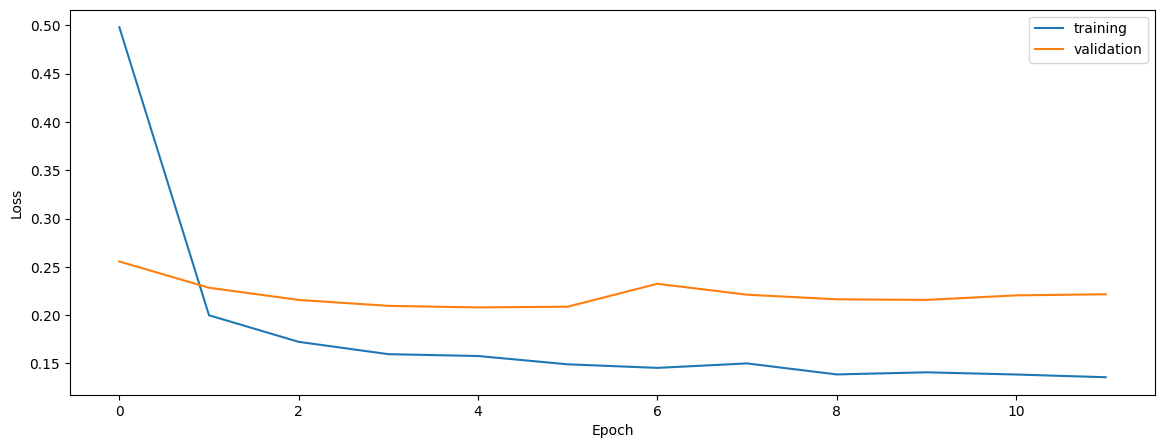

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.9405107715365809
0.9260848077493328
0.9345540113243621


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.9448781908309486
0.9406199673685127
0.9512367725794771


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9500317412087783
0.9486757810885829
0.9557773802246939


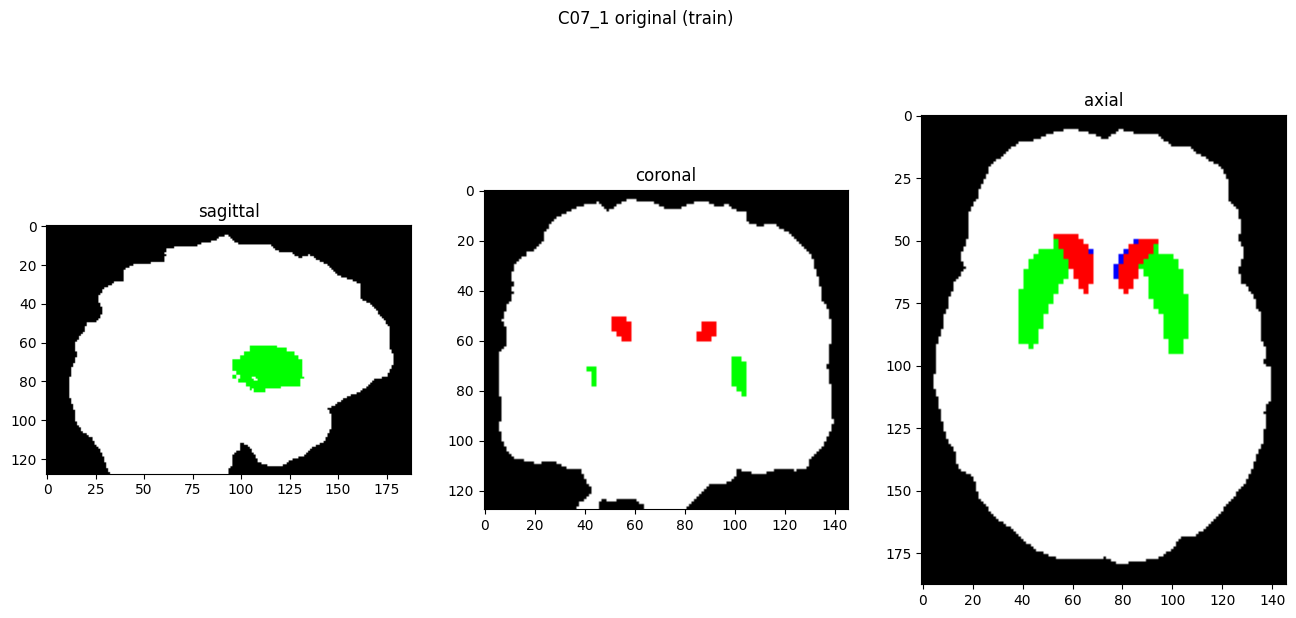

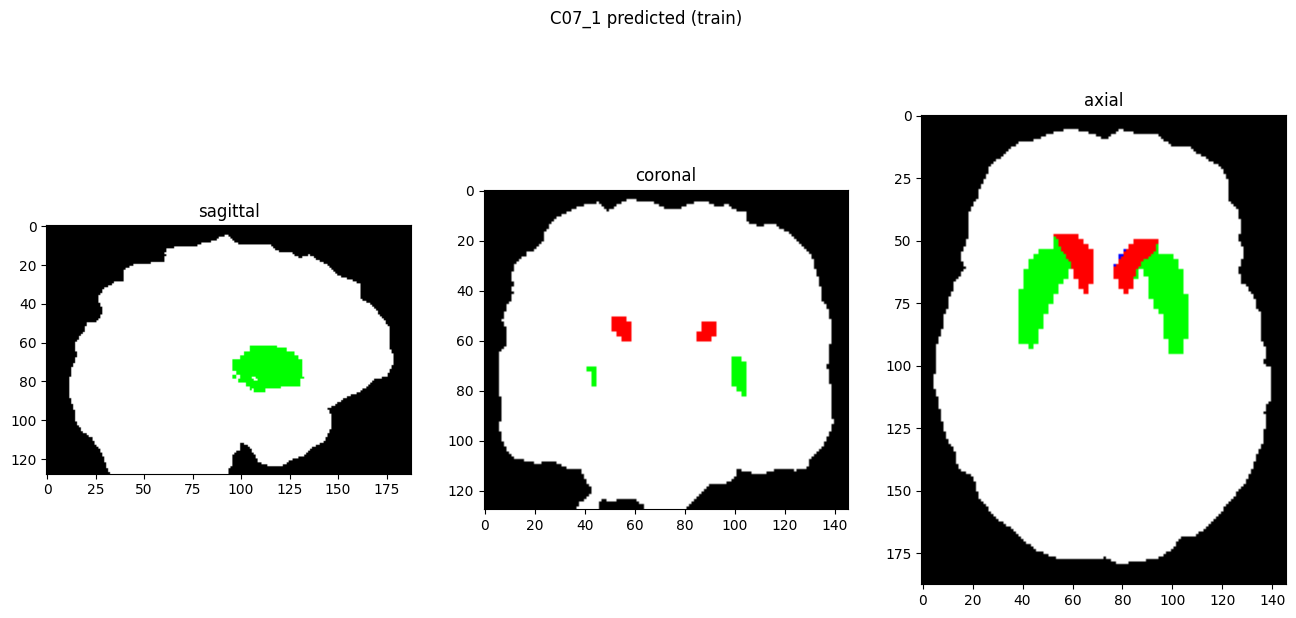

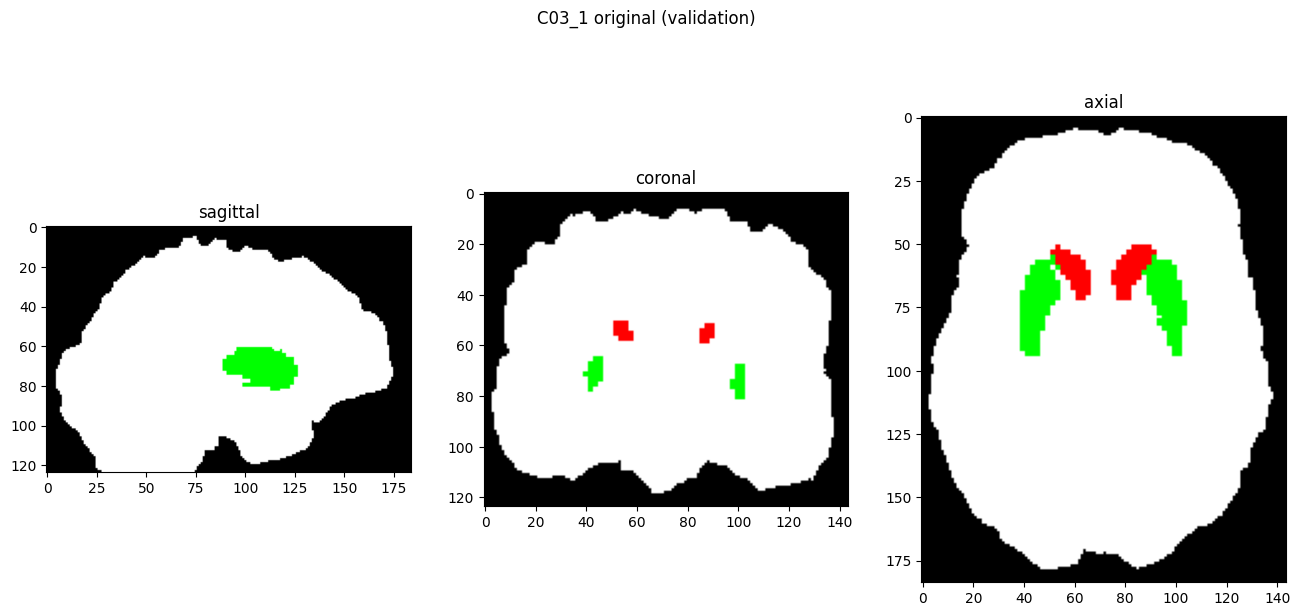

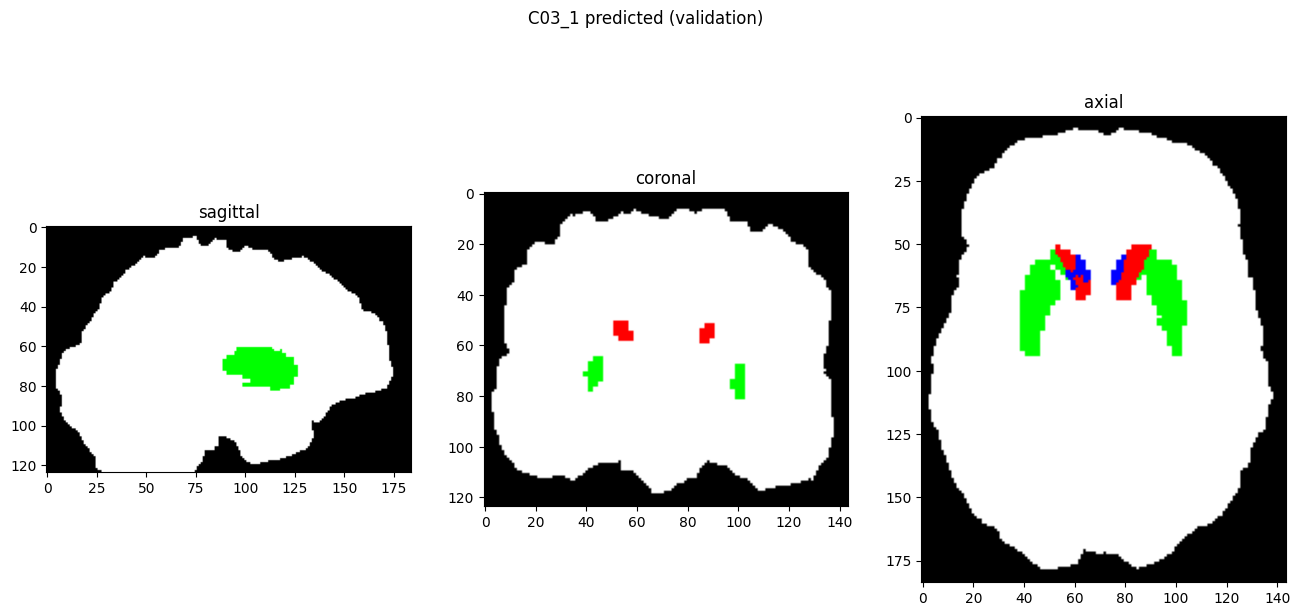

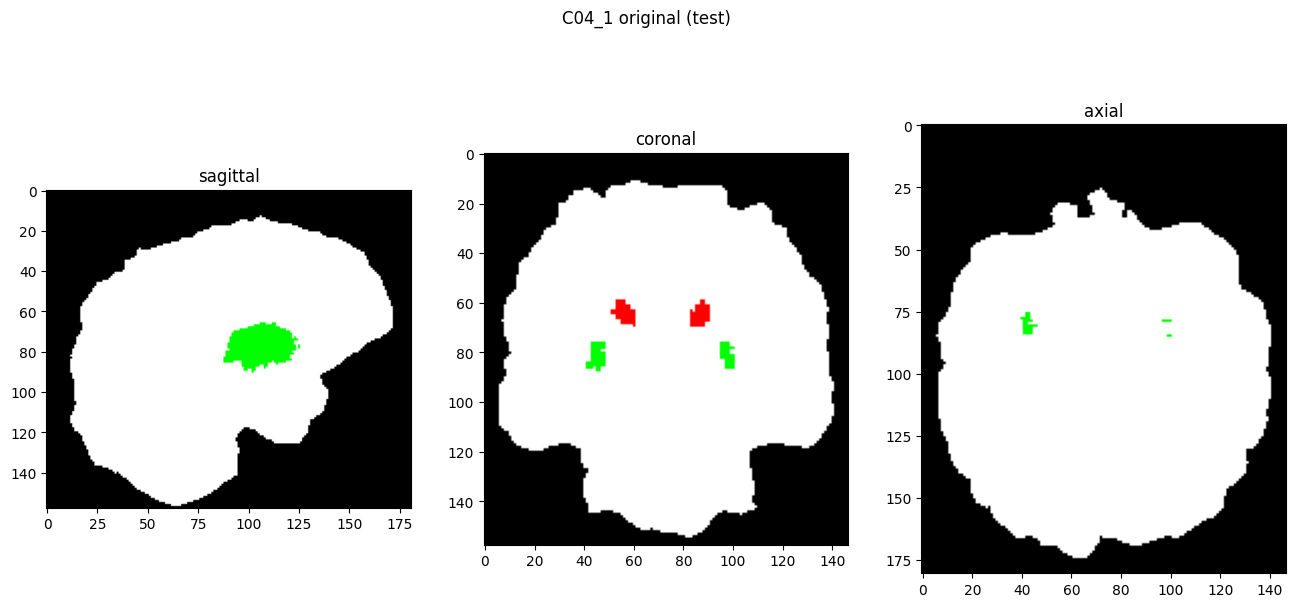

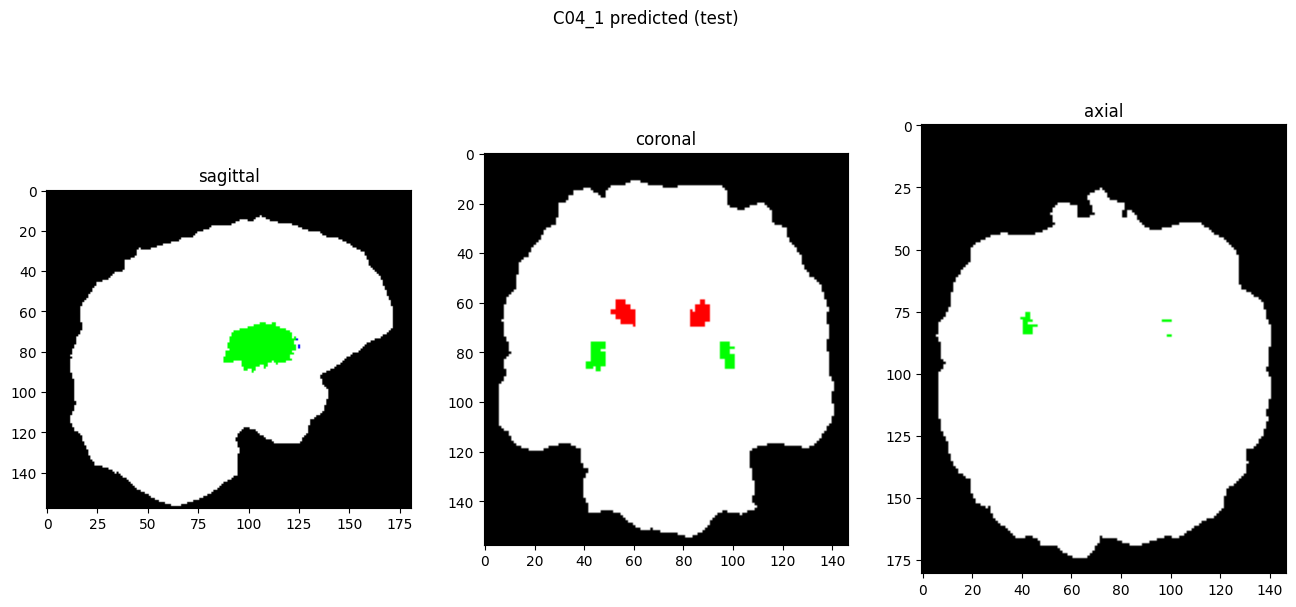

In [10]:
showResults(model, gen, threshold=0)